<a href="https://colab.research.google.com/github/cjsdudwls1/simple_things/blob/main/%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1_%ED%9A%8C%EA%B7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **필요한 라이브러리 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 사이킷런 관련 모듈
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# **타이타닉 데이터 가져오기**

In [ ]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
print("데이터셋 모양:", df.shape)
print(df.head())

데이터셋 모양: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500 

# **데이터 전처리 및 훈련/검증 데이터 분할**

In [ ]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [ ]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 범주형 변수 전처리: 'Sex'와 'Embarked'를 원-핫 인코딩 (첫번째 범주(drop_first=True) 제거하여 다중공선성 줄이기)
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)
print("\n전처리 후 데이터셋 모양:", df.shape)
print(df.head())

# 피처(X)와 타겟(y) 분리 ('Survived'가 타겟)
X = df.drop('Survived', axis=1)
y = df['Survived']

# 훈련데이터와 검증데이터 분할 (검증 데이터 20%, stratify로 클래스 비율 유지)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\n훈련 데이터 모양:", X_train.shape, y_train.shape)
print("검증 데이터 모양:", X_val.shape, y_val.shape)


전처리 후 데이터셋 모양: (891, 9)
   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500      True       False   
1         1       1  38.0      1      0  71.2833     False       False   
2         1       3  26.0      0      0   7.9250     False       False   
3         1       1  35.0      1      0  53.1000     False       False   
4         0       3  35.0      0      0   8.0500      True       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  

훈련 데이터 모양: (712, 8) (712,)
검증 데이터 모양: (179, 8) (179,)


# **로지스틱 회귀 모델에 랜덤서치(RandomizedSearchCV) 적용하여 최적의 모델 찾기**

In [ ]:
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)

# 하이퍼파라미터 분포 설정
param_dist = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 100)  # 10^-3 ~ 10^3 범위에서 검색
}

# RandomizedSearchCV 설정 (50회 반복, 5-폴드 교차검증)
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# 훈련 데이터에 대해 랜덤서치 수행
random_search.fit(X_train, y_train)

# 최적 모델 및 하이퍼파라미터 출력
best_model = random_search.best_estimator_
print("\n최적의 하이퍼파라미터:", random_search.best_params_)


최적의 하이퍼파라미터: {'penalty': 'l2', 'C': 0.08697490026177834}


# **검증 데이터에 대한 예측 및 혼동행렬 제시**


혼동행렬:
 [[100  10]
 [ 27  42]]

분류 성능 보고서:
               precision    recall  f1-score   support

           0       0.79      0.91      0.84       110
           1       0.81      0.61      0.69        69

    accuracy                           0.79       179
   macro avg       0.80      0.76      0.77       179
weighted avg       0.80      0.79      0.79       179



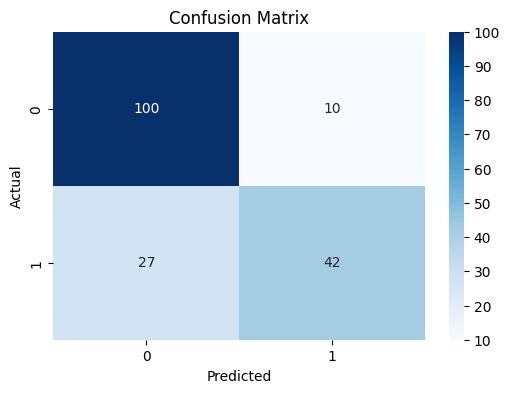

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# 1. 로지스틱 회귀 모델 객체 생성
# ------------------------------------------------------------------------------
# LogisticRegression: 이진 분류 문제에서 널리 사용하는 선형 모델
# solver='liblinear': 작은 데이터셋에 적합하며, L1 및 L2 정규화를 모두 지원하는 알고리즘 선택
# max_iter=1000: 모델이 수렴할 때까지 최대 1000번의 반복을 수행 (기본값보다 크게 설정하여 수렴 문제 예방)
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)

# 2. 하이퍼파라미터 검색 범위 설정
# ------------------------------------------------------------------------------
# 하이퍼파라미터: 모델 성능에 영향을 미치며 학습 전에 설정해야 하는 매개변수들
# 'penalty': 모델의 복잡도를 조절하는 정규화(규제) 방식 선택 ('l1'은 Lasso, 'l2'는 Ridge 정규화)
# 'C': 규제 강도의 역수로, 값이 작으면 강한 규제가 적용되어 과적합을 방지하고,
#      값이 크면 규제가 약해져 모델이 데이터에 더 잘 적합되지만 과적합 위험 증가
# np.logspace(-3, 3, 100): 10^(-3)부터 10^(3)까지 로그 스케일로 100개의 값을 생성
param_dist = {
    'penalty': ['l1', 'l2'],              # L1 및 L2 정규화 방식을 모두 탐색
    'C': np.logspace(-3, 3, 100)            # 10^-3부터 10^3까지의 값을 100개 생성하여 탐색
}

# 3. RandomizedSearchCV 객체 생성
# ------------------------------------------------------------------------------
# RandomizedSearchCV: 지정한 횟수만큼 무작위로 하이퍼파라미터 조합을 선택해 교차검증을 수행
# estimator: 평가할 기본 모델 (여기서는 로지스틱 회귀)
# param_distributions: 탐색할 하이퍼파라미터의 분포(혹은 리스트)
# n_iter: 시도할 하이퍼파라미터 조합의 수 (여기서는 50회 반복)
# cv: 교차검증을 위한 폴드 수 (5-폴드 교차검증)
# random_state: 결과의 재현성을 위한 난수 시드 (42로 설정)
# n_jobs: 병렬 처리를 위한 작업 개수 (-1은 사용 가능한 모든 프로세서를 사용)
random_search = RandomizedSearchCV(
    estimator=log_reg,            # 평가할 모델
    param_distributions=param_dist,  # 탐색할 하이퍼파라미터 분포
    n_iter=50,                    # 50개의 서로 다른 하이퍼파라미터 조합을 시도
    cv=5,                         # 5-폴드 교차검증을 수행하여 모델 성능 평가
    random_state=42,              # 결과 재현을 위한 난수 시드
    n_jobs=-1                     # 가능한 모든 CPU 코어 사용 (병렬 처리)
)

# 4. 훈련 데이터에 대해 랜덤 서치를 수행하여 최적의 하이퍼파라미터 탐색
# ------------------------------------------------------------------------------
# X_train: 특성(feature) 데이터셋 (훈련 데이터)
# y_train: 타겟(target) 데이터셋 (훈련 데이터)
# .fit() 메서드를 통해 각 하이퍼파라미터 조합에 대해 5-폴드 교차검증을 수행하고,
# 최적의 성능을 보이는 조합을 선택하게 됨
random_search.fit(X_train, y_train)

# 5. 최적 모델 및 하이퍼파라미터 출력
# ------------------------------------------------------------------------------
# best_estimator_: 최적의 하이퍼파라미터로 학습된 모델 객체
# best_params_: 최적의 성능을 보인 하이퍼파라미터 조합 (딕셔너리 형태)
best_model = random_search.best_estimator_
print("\n최적의 하이퍼파라미터:", random_search.best_params_)


# **전체 정확도 79%는 준수하지만, 생존자 판별(Recall=0.61)을 더 개선할 필요가 있음.**
**임곗값 조정, 추가 피처 발굴 등으로 재현율을 높일 수 있음.**